In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.ticker import AutoMinorLocator, MultipleLocator
from matplotlib._cm import _Set3_data  # qualitative colors
from mpltern.datasets import soil_texture_classes  # USDA polygons

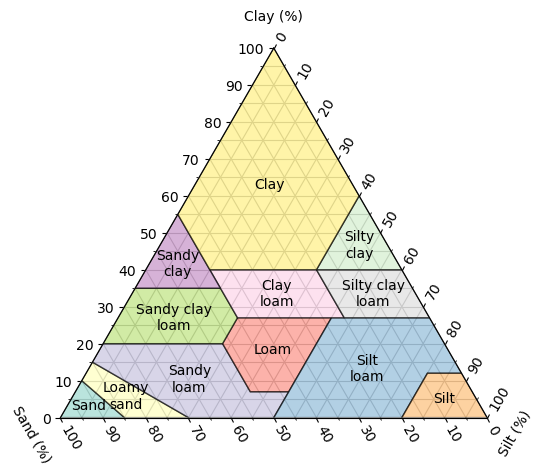

In [4]:
def calculate_centroid(vertices):
    """
    Compute centroid of a 2D polygon given an (N, 2) array of vertices.
    Uses the standard shoelace formula (no np.cross).
    """
    x = vertices[:, 0]
    y = vertices[:, 1]

    # Close the polygon
    x_next = np.roll(x, -1)
    y_next = np.roll(y, -1)

    cross = x * y_next - x_next * y
    area = cross.sum() / 2.0

    if np.isclose(area, 0.0):
        # Fallback: simple mean if area is ~0 (degenerate polygon)
        return np.array([x.mean(), y.mean()])

    cx = ((x + x_next) * cross).sum() / (6.0 * area)
    cy = ((y + y_next) * cross).sum() / (6.0 * area)

    return np.array([cx, cy])



def plot_soil_texture_classes(ax):
    """Plot soil texture classes."""
    classes = soil_texture_classes

    for (key, value), color in zip(classes.items(), _Set3_data):
        tn0, tn1, tn2 = np.array(value).T
        patch = ax.fill(tn0, tn1, tn2, ec="k", fc=color, alpha=0.6, zorder=2.1)
        centroid = calculate_centroid(patch[0].get_xy())

        # last space replaced with line break
        label = key[::-1].replace(" ", "\n", 1)[::-1].capitalize()

        ax.text(
            centroid[0],
            centroid[1],
            label,
            ha="center",
            va="center",
            transform=ax.transData,
        )

    ax.taxis.set_major_locator(MultipleLocator(10.0))
    ax.laxis.set_major_locator(MultipleLocator(10.0))
    ax.raxis.set_major_locator(MultipleLocator(10.0))

    ax.taxis.set_minor_locator(AutoMinorLocator(2))
    ax.laxis.set_minor_locator(AutoMinorLocator(2))
    ax.raxis.set_minor_locator(AutoMinorLocator(2))

    ax.grid(which="both")

    ax.set_tlabel("Clay (%)")
    ax.set_llabel("Sand (%)")
    ax.set_rlabel("Silt (%)")

    ax.taxis.set_ticks_position("tick2")
    ax.laxis.set_ticks_position("tick2")
    ax.raxis.set_ticks_position("tick2")


def main():
    """Main"""
    ax = plt.subplot(projection="ternary", ternary_sum=100.0)
    plot_soil_texture_classes(ax)
    # add plot here on top of USDA soil texture classes with zorder of e.g. 2.5
    plt.show()


if __name__ == "__main__":
    main()

In [ ]:
# -------------- example dataset (replace with your CSV) -------------- #
# Create a small example DataFrame; you can delete this and load a CSV instead
example_df = pd.DataFrame(
    {
        "sample_id": ["S1", "S2", "S3", "S4"],
        "sand": [60, 35, 20, 80],
        "silt": [20, 40, 40, 10],
        "clay": [20, 25, 40, 10],
    }
)

# -------------- main plotting function -------------- #
def plot_soil_samples(df, sand_col="sand", silt_col="silt", clay_col="clay"):
    """
    Plot USDA soil texture triangle with sample points.

    df: pandas DataFrame with sand, silt, clay columns (percent, summing ~100).
    """
    # Basic validation
    required = {sand_col, silt_col, clay_col}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"Missing columns in DataFrame: {missing}")

    # Make sure percentages roughly sum to 100
    sums = df[sand_col] + df[silt_col] + df[clay_col]
    if not np.allclose(sums, 100.0, atol=1.0):
        print("Warning: some rows do not sum to 100±1%. Check your data.")

    # Create ternary subplot; ternary_sum=100 means axes are in percent [web:4]
    fig = plt.figure(figsize=(7, 6))
    ax = fig.add_subplot(projection="ternary", ternary_sum=100.0)

    # Plot USDA background
    plot_usda_texture_classes(ax)

    # Extract sample coordinates in USDA order (t,l,r) = (clay, sand, silt) [web:4]
    t = df[clay_col].to_numpy()
    l = df[sand_col].to_numpy()
    r = df[silt_col].to_numpy()

    # Scatter points on top
    sc = ax.scatter(
        t,
        l,
        r,
        c="black",
        s=40,
        edgecolors="white",
        linewidths=0.5,
        zorder=3.0,
        label="Samples",
    )

    # Optional: label each point with sample_id if present
    if "sample_id" in df.columns:
        for (_, row), tt, ll, rr in zip(df.iterrows(), t, l, r):
            ax.text(
                tt,
                ll,
                rr,
                row["sample_id"],
                fontsize=7,
                ha="center",
                va="center",
                color="black",
                zorder=3.5,
            )

    ax.set_title("USDA Soil Texture Triangle with Samples", pad=20)
    plt.tight_layout()
    return fig, ax


# -------------- run example -------------- #
fig, ax = plot_soil_samples(example_df)
plt.show()
